## Step 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Step 2: Load Your Data

In [5]:
# Load the data you created in the feature engineering step
comps_df = pd.read_csv('data/model_ready/comps_pairs_model_ready.csv')
candidates_df = pd.read_csv('data/model_ready/candidates_pair_model_ready.csv')

# Check the sizes
print(f"Comps (positive examples): {len(comps_df)}")
print(f"Candidates (to classify): {len(candidates_df)}")

Comps (positive examples): 264
Candidates (to classify): 9820


## Step 3: Create Labels 

In [6]:
# Add labels: 1 for comps (good comparables)
comps_df['is_good_comp'] = 1

# For negatives, we'll sample from candidates
# We assume most candidates are NOT good comps, so this is reasonable

# Create a list to store our sampled negatives
negative_samples = []

# For each subject property, sample some candidates as negative examples
for order_id in comps_df['orderID'].unique():
    # Get all candidates for this subject
    order_candidates = candidates_df[candidates_df['orderID'] == order_id]
    
    if len(order_candidates) > 0:
        # Count how many positive examples we have for this subject
        n_positives = len(comps_df[comps_df['orderID'] == order_id])
        
        # Sample 3x as many negatives (this is a common ratio)
        # But don't sample more than available
        n_to_sample = min(n_positives * 3, len(order_candidates))
        
        # Randomly sample candidates
        sampled = order_candidates.sample(n=n_to_sample, random_state=42)
        negative_samples.append(sampled)

# Combine all negative samples
negative_df = pd.concat(negative_samples, ignore_index=True)
negative_df['is_good_comp'] = 0

# Combine positive and negative examples
train_df = pd.concat([comps_df, negative_df], ignore_index=True)

# Check the balance
print(f"\nTraining set created:")
print(f"Total examples: {len(train_df)}")
print(f"Positive examples: {len(train_df[train_df['is_good_comp']==1])}")
print(f"Negative examples: {len(train_df[train_df['is_good_comp']==0])}")
print(f"Positive ratio: {len(train_df[train_df['is_good_comp']==1]) / len(train_df):.2%}")


Training set created:
Total examples: 1047
Positive examples: 264
Negative examples: 783
Positive ratio: 25.21%


## Step 4: Prepare Features for Machine Learning


In [7]:
# List all our feature columns (the differences and matches we calculated)
feature_cols = [
    'gla_diff',           # Gross Living Area difference
    'lot_size_diff',      # Lot size difference  
    'bedroom_diff',       # Bedroom count difference
    'bathroom_diff',      # Bathroom count difference
    'room_count_diff',    # Total room count difference
    'same_property_type', # Same property type? (1 or 0)
    'same_storey_type',   # Same storey type? (1 or 0)
    'sold_recently_90',   # Sold within 90 days? (1 or 0)
    'sold_recently_180'   # Sold within 180 days? (1 or 0)
]

# Create our feature matrix (X) and target vector (y)
X = train_df[feature_cols].copy()
y = train_df['is_good_comp']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (1047, 9)
Target vector shape: (1047,)


## Step 5: Handle Missing Values


In [8]:
# Check for missing values
print("Missing values in each feature:")
print(X.isnull().sum())
print("\n")

# Fill missing values with sensible defaults
# For differences: use the median (middle value)
numerical_features = ['gla_diff', 'lot_size_diff', 'bedroom_diff', 
                     'bathroom_diff', 'room_count_diff']

for feature in numerical_features:
    median_value = X[feature].median()
    X[feature] = X[feature].fillna(median_value)
    print(f"Filled {feature} missing values with median: {median_value}")

# For binary features: use 0 (assuming missing = not matching/not recent)
binary_features = ['same_property_type', 'same_storey_type', 
                  'sold_recently_90', 'sold_recently_180']

for feature in binary_features:
    X[feature] = X[feature].fillna(0)
    print(f"Filled {feature} missing values with 0")

print("\nMissing values after filling:")
print(X.isnull().sum())

Missing values in each feature:
gla_diff               16
lot_size_diff         399
bedroom_diff           20
bathroom_diff          12
room_count_diff        18
same_property_type     14
same_storey_type      143
sold_recently_90        0
sold_recently_180       0
dtype: int64


Filled gla_diff missing values with median: 425.0
Filled lot_size_diff missing values with median: 2224.4559999999997
Filled bedroom_diff missing values with median: 1.0
Filled bathroom_diff missing values with median: 1.0
Filled room_count_diff missing values with median: 2.0
Filled same_property_type missing values with 0
Filled same_storey_type missing values with 0
Filled sold_recently_90 missing values with 0
Filled sold_recently_180 missing values with 0

Missing values after filling:
gla_diff              0
lot_size_diff         0
bedroom_diff          0
bathroom_diff         0
room_count_diff       0
same_property_type    0
same_storey_type      0
sold_recently_90      0
sold_recently_180     0
dtype: 

## Step 6: Split Data into Training and Testing Sets


In [9]:
# Split 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing
    random_state=42,    # For reproducibility
    stratify=y          # Keep same positive/negative ratio in both sets
)

print(f"Training set: {len(X_train)} examples")
print(f"Test set: {len(X_test)} examples")
print(f"\nPositive ratio in training: {y_train.mean():.2%}")
print(f"Positive ratio in test: {y_test.mean():.2%}")

Training set: 837 examples
Test set: 210 examples

Positive ratio in training: 25.21%
Positive ratio in test: 25.24%


## Step 7: Train a Simple Model - Random Forest
Random Forest is beginner-friendly because:

It doesn't need feature scaling
It handles non-linear relationships
It's hard to overfit
It provides feature importance

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Create the model
rf_model = RandomForestClassifier(
    n_estimators=100,    # Number of trees
    random_state=42,     # For reproducibility
    n_jobs=-1           # Use all CPU cores
)

# Train the model
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Training complete!")

# Make predictions on test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of being class 1

Training Random Forest model...
Training complete!


Accuracy: 89.05%

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       157
           1       0.81      0.74      0.77        53

    accuracy                           0.89       210
   macro avg       0.86      0.84      0.85       210
weighted avg       0.89      0.89      0.89       210



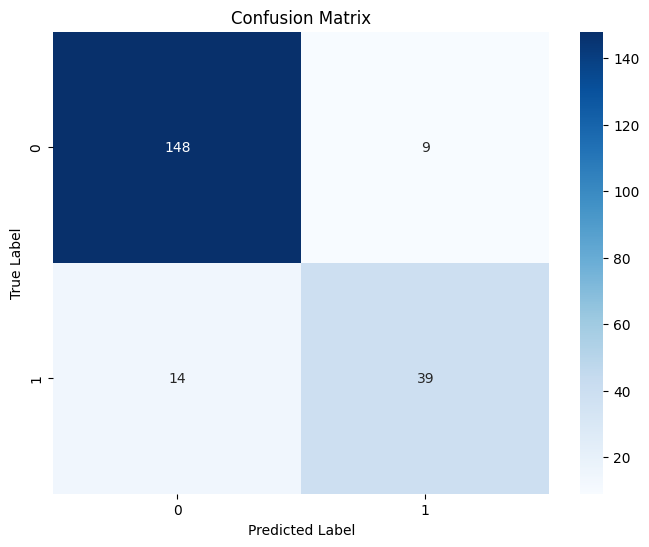


ROC AUC Score: 0.948


In [11]:
# Calculate accuracy
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy:.2%}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC AUC Score (good for imbalanced data)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {auc_score:.3f}")

## Step 9: Feature Importance Analysis

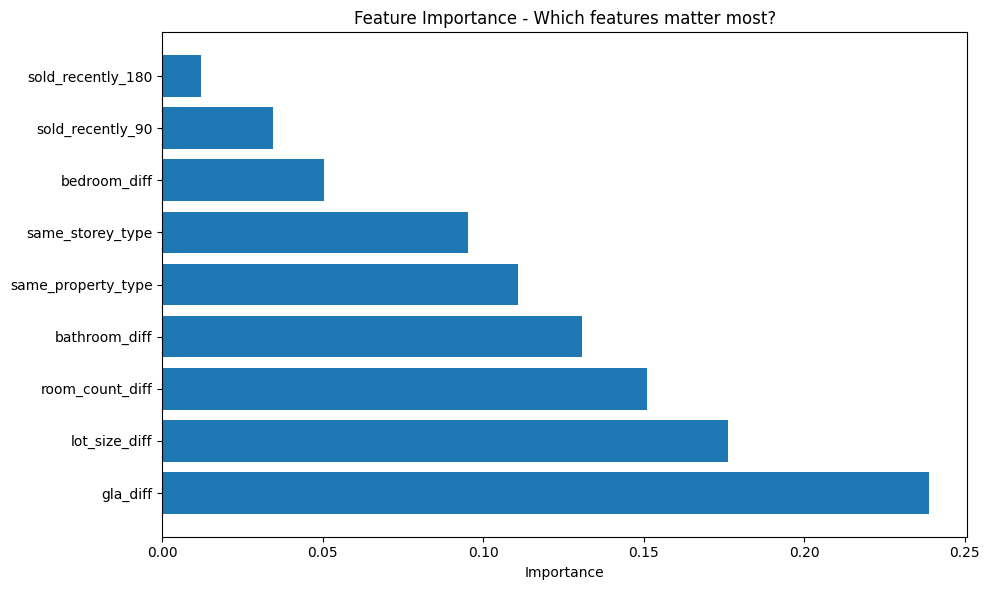

Top 3 most important features:
gla_diff: 0.239
lot_size_diff: 0.176
room_count_diff: 0.151


In [12]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Which features matter most?')
plt.tight_layout()
plt.show()

print("Top 3 most important features:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

## Step 10: Alternative Strategy - Using Class Weights


In [13]:
# Calculate class weights to balance the dataset
from sklearn.utils.class_weight import compute_class_weight

# If using all candidates as negatives
all_candidates_df = candidates_df.copy()
all_candidates_df['is_good_comp'] = 0

# Combine with positive examples
train_df_all = pd.concat([comps_df, all_candidates_df], ignore_index=True)

# Calculate class weights
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df_all['is_good_comp'])
class_weight_dict = dict(zip(classes, class_weights))

print(f"Class weights: {class_weight_dict}")
print(f"This means positive examples will be weighted {class_weight_dict[1]:.1f}x more than negatives")

# Train model with class weights
rf_model_weighted = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weight_dict,  # Apply weights!
    random_state=42,
    n_jobs=-1
)

# Prepare data
X_all = train_df_all[feature_cols].fillna(0)  # Simple fill for demo
y_all = train_df_all['is_good_comp']

# Split and train
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

rf_model_weighted.fit(X_train_all, y_train_all)

# Evaluate
y_pred_weighted = rf_model_weighted.predict(X_test_all)
print("\nWeighted Model Results:")
print(classification_report(y_test_all, y_pred_weighted))

Class weights: {0: 0.5134419551934827, 1: 19.098484848484848}
This means positive examples will be weighted 19.1x more than negatives

Weighted Model Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1964
           1       0.78      0.40      0.53        53

    accuracy                           0.98      2017
   macro avg       0.88      0.70      0.76      2017
weighted avg       0.98      0.98      0.98      2017



## Step 11: Make Predictions on New Candidates


In [14]:
# Prepare candidates for prediction
X_candidates = candidates_df[feature_cols].copy()

# Fill missing values (same as training)
for feature in numerical_features:
    X_candidates[feature] = X_candidates[feature].fillna(X[feature].median())
for feature in binary_features:
    X_candidates[feature] = X_candidates[feature].fillna(0)

# Make predictions
predictions = rf_model.predict(X_candidates)
probabilities = rf_model.predict_proba(X_candidates)[:, 1]

# Add to dataframe
candidates_df['is_good_comp_predicted'] = predictions
candidates_df['probability_good_comp'] = probabilities

# Show top 10 most likely good comps
top_candidates = candidates_df.nlargest(10, 'probability_good_comp')
print("Top 10 most likely good comparables:")
print(top_candidates[['orderID', 'probability_good_comp']].to_string())

# Save results
output_df = candidates_df[['orderID', 'is_good_comp_predicted', 'probability_good_comp']]
output_df.to_csv('predicted_comparables.csv', index=False)
print("\nPredictions saved to 'predicted_comparables.csv'")

Top 10 most likely good comparables:
      orderID  probability_good_comp
1856  4760900                   1.00
1872  4760900                   1.00
7997  4776066                   1.00
859   4762330                   0.98
1894  4760900                   0.98
7963  4776066                   0.97
1910  4742669                   0.96
8276  4777578                   0.96
6480  4768014                   0.95
7875  4772152                   0.95

Predictions saved to 'predicted_comparables.csv'
